Silhouette Score for Clustering: 0.3098627312973825


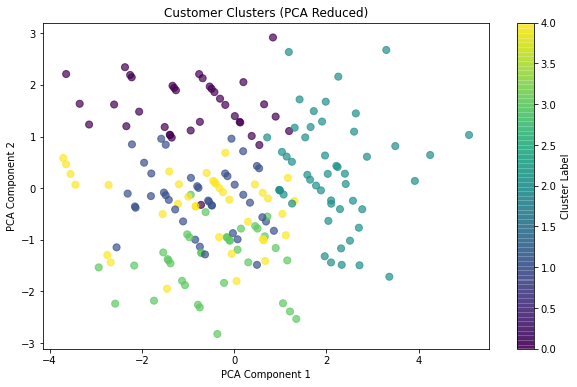

Model Explanation:
1. Data is preprocessed to aggregate customer-level features such as total spending, average transaction value, etc.
2. One-hot encoding is used to convert categorical preferred category into numerical format.
3. Features are normalized using StandardScaler to ensure all values are on a comparable scale.
4. Cosine similarity is computed to measure customer similarity based on their profiles and transaction behavior.
5. For the first 20 customers, top 3 similar customers with similarity scores are recommended.
6. K-Means clustering is applied to segment customers into 5 groups based on their profiles.
7. Clustering evaluation using Silhouette Score yields a value of 0.3098627312973825.
8. PCA is used to visualize clusters in a 2D space for better interpretation.
Example Recommendations:
Customer C0001: [('C0072', 0.9847298141121051), ('C0190', 0.9833195344635149), ('C0069', 0.973187740690127)]
Customer C0002: [('C0029', 0.9995029783722177), ('C0010', 0.998286470662004

In [5]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load datasets
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

# Merge data
merged = transactions.merge(customers, on="CustomerID", how="left").merge(products, on="ProductID", how="left")

# Feature engineering
customer_features = merged.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    avg_transaction_value=("TotalValue", "mean"),
    transaction_count=("TransactionID", "count"),
    unique_products=("ProductID", "nunique"),
    preferred_category=("Category", lambda x: x.mode()[0] if len(x.mode()) > 0 else None)
).reset_index()

# One-hot encode the preferred category
customer_features = pd.get_dummies(customer_features, columns=["preferred_category"], drop_first=True)

# Normalize data for similarity computation
scaler = StandardScaler()
feature_columns = [col for col in customer_features.columns if col not in ["CustomerID"]]
scaled_features = scaler.fit_transform(customer_features[feature_columns])

# Compute cosine similarity
similarity_matrix = cosine_similarity(scaled_features)
similarity_df = pd.DataFrame(similarity_matrix, index=customer_features["CustomerID"], columns=customer_features["CustomerID"])

# Generate recommendations
lookalike_results = {}
for customer_id in customer_features["CustomerID"][:20]:  # First 20 customers
    similar_customers = similarity_df[customer_id].sort_values(ascending=False).iloc[1:4]  # Top 3 excluding self
    lookalike_results[customer_id] = list(zip(similar_customers.index, similar_customers.values))

# Save results to Lookalike.csv
lookalike_df = pd.DataFrame({
    "CustomerID": lookalike_results.keys(),
    "Lookalikes": [str(value) for value in lookalike_results.values()]
})
lookalike_df.to_csv("Ayati_Sonkar_Lookalike.csv", index=False)

# Perform clustering (K-Means)
kmeans = KMeans(n_clusters=5, random_state=42)
customer_features["Cluster"] = kmeans.fit_predict(scaled_features)

# Evaluate clustering using Silhouette Score (Fallback)
def calculate_silhouette_score(features, labels):
    return silhouette_score(features, labels)

silhouette_avg = calculate_silhouette_score(scaled_features, customer_features["Cluster"])
print(f"Silhouette Score for Clustering: {silhouette_avg}")

# Visualize clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=customer_features["Cluster"], cmap="viridis", s=50, alpha=0.7)
plt.title("Customer Clusters (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster Label")
plt.show()

# Detailed explanations of the model
print("Model Explanation:")
print("1. Data is preprocessed to aggregate customer-level features such as total spending, average transaction value, etc.")
print("2. One-hot encoding is used to convert categorical preferred category into numerical format.")
print("3. Features are normalized using StandardScaler to ensure all values are on a comparable scale.")
print("4. Cosine similarity is computed to measure customer similarity based on their profiles and transaction behavior.")
print("5. For the first 20 customers, top 3 similar customers with similarity scores are recommended.")
print("6. K-Means clustering is applied to segment customers into 5 groups based on their profiles.")
print(f"7. Clustering evaluation using Silhouette Score yields a value of {silhouette_avg}.")
print("8. PCA is used to visualize clusters in a 2D space for better interpretation.")

# Print example recommendations for the first 5 customers
print("Example Recommendations:")
for customer_id, lookalikes in list(lookalike_results.items())[:5]:
    print(f"Customer {customer_id}: {lookalikes}")

